# Analysing the Canadian Federal Election of 2019

**Sources**:

- Boundary dataset from https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/bound-limit-eng.cfm.
- Election results dataset from https://elections.ca.

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib
import pandas

## Data Processing

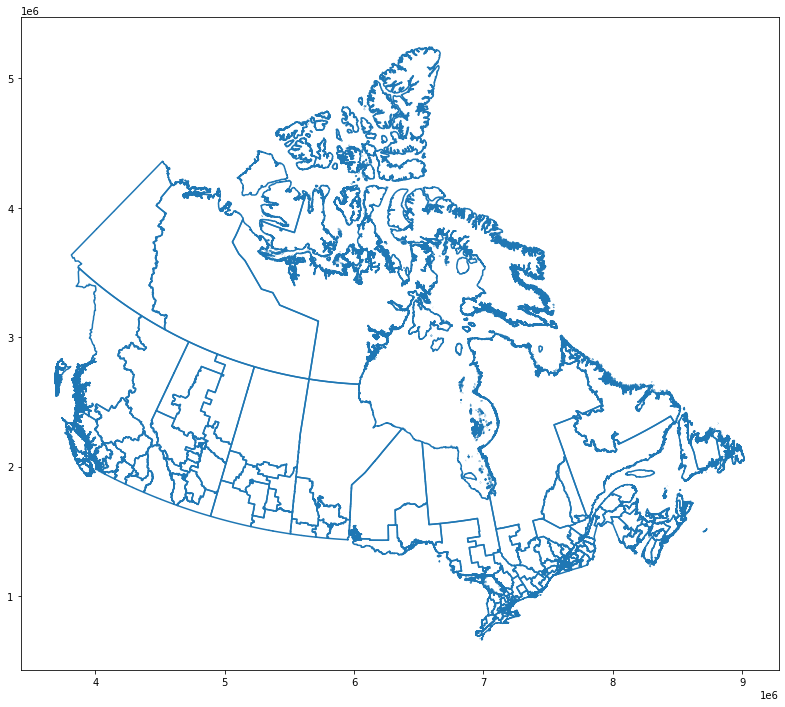

In [5]:
districts = gpd.read_file("data/canada-electoral-districts.shp")

districts.boundary.plot(figsize=(24, 12), )

In [7]:
results = pandas.read_csv("data/election-2019-results.csv")
results

,Electoral District Number/Numéro de circonscription,Electoral District Name_English/Nom de circonscription_Anglais,Electoral District Name_French/Nom de circonscription_Français,Polling Station Number/Numéro du bureau de scrutin,Polling Station Name/Nom du bureau de scrutin,Void Poll Indicator/Indicateur de bureau supprimé,No Poll Held Indicator/Indicateur de bureau sans scrutin,Merge With/Fusionné avec,Rejected Ballots for Polling Station/Bulletins rejetés du bureau,Electors for Polling Station/Électeurs du bureau,Candidate’s Family Name/Nom de famille du candidat,Candidate’s Middle Name/Second prénom du candidat,Candidate’s First Name/Prénom du candidat,Political Affiliation Name_English/Appartenance politique_Anglais,Political Affiliation Name_French/Appartenance politique_Français,Incumbent Indicator/Indicateur_Candidat sortant,Elected Candidate Indicator/Indicateur du candidat élu,Candidate Poll Votes Count/Votes du candidat pour le bureau
0,10001,Avalon,Avalon,1,Freshwater,N,N,NaN,0,121,Chapman,NaN,Matthew,Conservative,Conservateur,N,N,33
1,10001,Avalon,Avalon,1,Freshwater,N,N,NaN,0,121,Malone,NaN,Greg,Green Party,Parti Vert,N,N,7
2,10001,Avalon,Avalon,1,Freshwater,N,N,NaN,0,121,McDonald,NaN,Kenneth,Liberal,Libéral,Y,Y,56
3,10001,Avalon,Avalon,1,Freshwater,N,N,NaN,0,121,Movelle,NaN,Lea Mary,NDP-New Democratic Party,NPD-Nouveau Parti démocratique,N,N,14
4,10001,Avalon,Avalon,2,Victoria,N,N,NaN,0,332,Chapman,NaN,Matthew,Conservative,Conservateur,N,N,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480918,62001,Nunavut,Nunavut,S/R 1,SVR Group 1/RÉS Groupe 1,N,N,NaN,2,115,Roy,NaN,Douglas,Green Party,Parti Vert,N,N,5
480919,62001,Nunavut,Nunavut,S/R 2,SVR Group 2/RÉS Groupe 2,N,N,NaN,8,0,Aglukkaq,NaN,Leona,Conservative,Conservateur,N,N,78
480920,62001,Nunavut,Nunavut,S/R 2,SVR Group 2/RÉS Groupe 2,N,N,NaN,8,0,Pizzo Lyall,NaN,Megan,Liberal,Libéral,N,N,145
480921,62001,Nunavut,Nunavut,S/R 2,SVR Group 2/RÉS Groupe 2,N,N,NaN,8,0,Qaqqaq,NaN,Mumilaaq,NDP-New Democratic Party,NPD-Nouveau Parti démocratique,N,Y,134


In [8]:
# Group the poll results by district
results_by_district = results.groupby(
    by="Electoral District Name_English/Nom de circonscription_Anglais", as_index=False
).aggregate({
    "Candidate Poll Votes Count/Votes du candidat pour le bureau": np.sum
})
results_by_district.rename(columns={"Candidate Poll Votes Count/Votes du candidat pour le bureau": "District Total"}, inplace=True)

# Group the poll results by candidate
results_by_candidate = results.groupby(by=[
    "Electoral District Name_English/Nom de circonscription_Anglais",
    "Candidate’s Family Name/Nom de famille du candidat",
    "Candidate’s First Name/Prénom du candidat",
    "Political Affiliation Name_English/Appartenance politique_Anglais",
    "Elected Candidate Indicator/Indicateur du candidat élu"],
    as_index=False
).aggregate({
    "Candidate Poll Votes Count/Votes du candidat pour le bureau": np.sum
})

# Use vote totals to compute percentages for each candidate
full_data = pandas.merge(results_by_candidate, results_by_district)
full_data["Vote Percentage"] = full_data["Candidate Poll Votes Count/Votes du candidat pour le bureau"] / full_data["District Total"]

In [9]:
# Merge the election data with the geospatial district boundary data
full_district_data = pandas.merge(districts, full_data, how="outer", left_on="FEDENAME", right_on="Electoral District Name_English/Nom de circonscription_Anglais")
winners_district_data = full_district_data[full_district_data["Elected Candidate Indicator/Indicateur du candidat élu"] == "Y"]

## Making the Map Plots

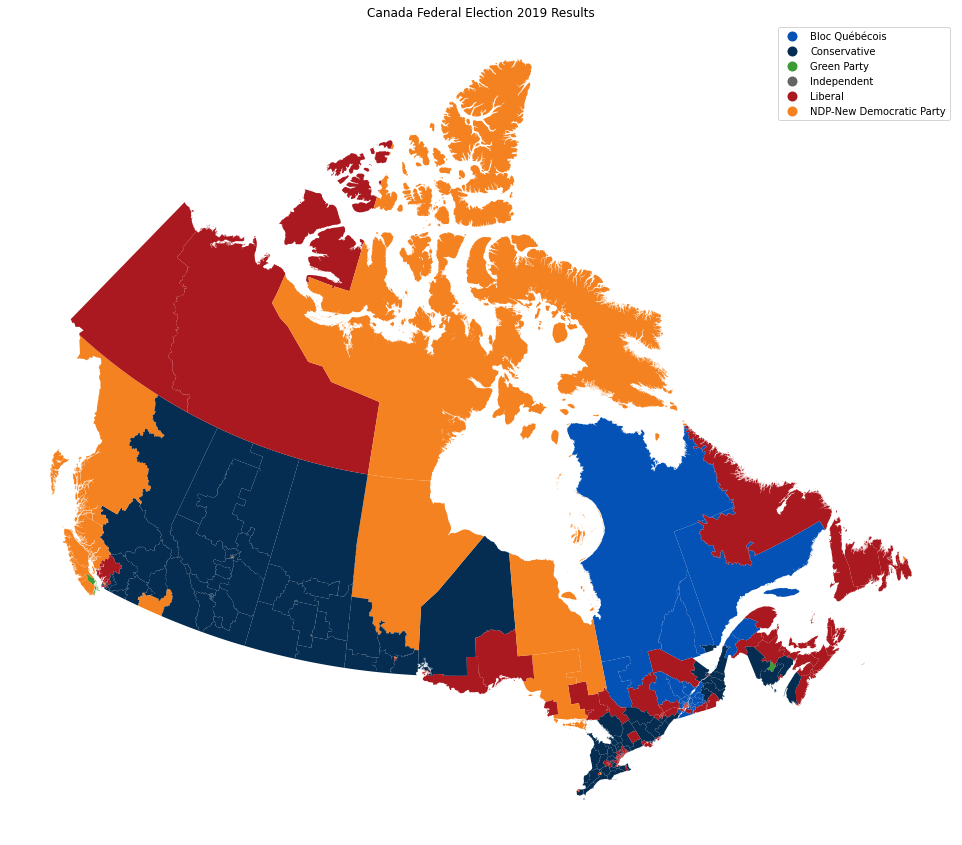

In [ ]:
plot = winners_district_data.plot(
    column="Political Affiliation Name_English/Appartenance politique_Anglais",
    linewidth=0.8,
    figsize=(30, 15),
    legend=True,
    categorical=True,
    categories=[
        'Bloc Québécois',
        'Conservative',
        'Green Party',
        'Independent',
        'Liberal',
        'NDP-New Democratic Party'
    ],
    cmap=matplotlib.colors.ListedColormap(np.array([
        [4, 82, 181],
        [5, 45, 82],
        [61, 155, 53],
        [100, 100, 100],
        [170, 25, 31],
        [245, 130, 32],
    ]) / 255)
)
plot.set_title("Canada Federal Election 2019 Results")
plot.set_axis_off()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


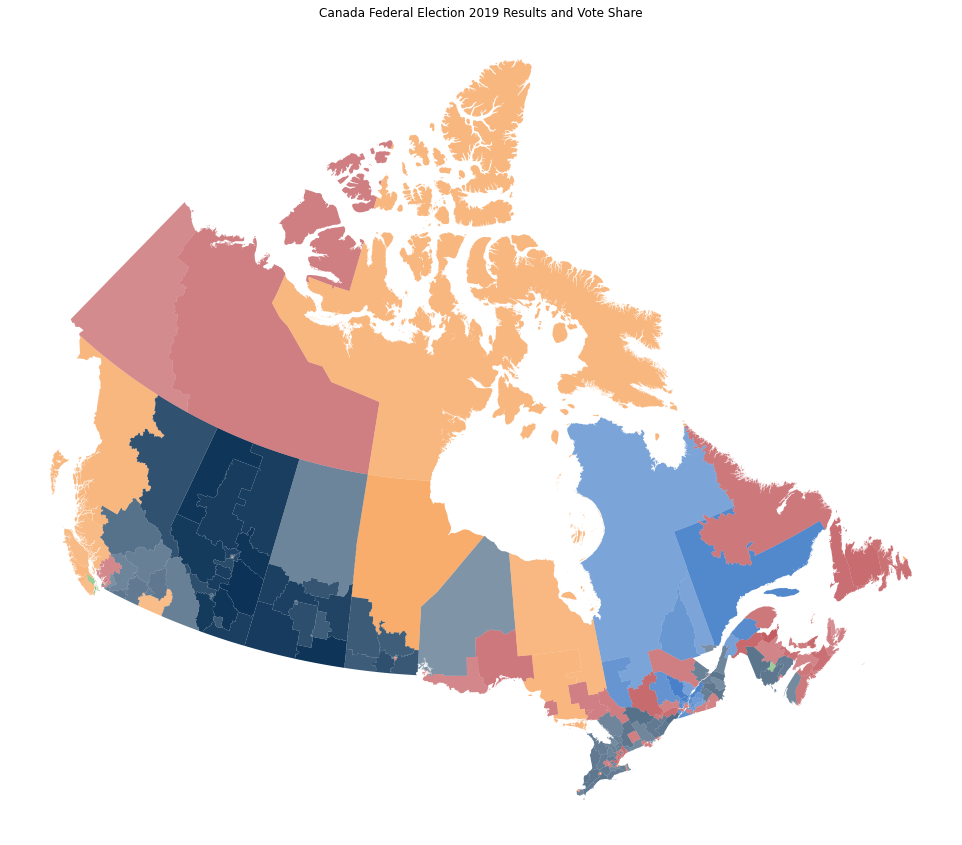

In [11]:
def get_colour(row):
  colour_map = {
    'Bloc Québécois': [4 / 255, 82 / 255, 181 / 255],
    'Conservative': [5 / 255, 45 / 255, 82 / 255],
    'Green Party': [61 / 255, 155 / 255, 53 / 255],
    'Independent': [100 / 255, 100 / 255, 100 / 255],
    'Liberal': [170 / 255, 25 / 255, 31 / 255],
    'NDP-New Democratic Party': [245 / 255, 130 / 255, 32 / 255],
  }

  return matplotlib.colors.to_hex(colour_map[row["Political Affiliation Name_English/Appartenance politique_Anglais"]] + [0.2 + 0.9 * row["Vote Percentage"]], keep_alpha=True)


winners_district_data["color"] = winners_district_data.apply(get_colour, axis=1)
plot = winners_district_data.plot(
  linewidth=0.8,
  figsize=(30, 15),
  legend=True,
  color=winners_district_data["color"]
)
plot.set_title("Canada Federal Election 2019 Results and Vote Share")
plot.set_axis_off()